## Import Statements

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import folium
from folium import plugins
from folium.plugins import HeatMap
from math import sin, cos, sqrt, atan2, radians
import random
import timeit

## Number of incorrectly parked bicycles

### Marburg

In [59]:
marburg = pd.read_pickle('../0_data/marburg_clean.pkl')
marburg_stations = pd.read_pickle('../0_data/stations/marburg_stations.pkl')

### Calculate distance to nearest station for each trip

We will use scikit learns BallTree to calculate the distance to the nearest station and each trips' destination location.
BallTree allows us to choose haversine as a metric.
The haversine metric calculates distances of two points on a ball, which we will use to 

In [60]:
from sklearn.neighbors import BallTree

# calculate the nearest station of each trip as well as the distance in km
def calc_nearest_station(trips, stations):
    R = 6373000 # approximate radius of the earth in m
    
    # initialize balltree with correct metric and transform our coordinates from degree to radians
    bt = BallTree(np.deg2rad(stations), metric='haversine')
    # calculate the distances from every trip to the nearest station
    distances, indices = bt.query(np.deg2rad(trips))
    
    # we return the distances together with the indeces of the nearest stations
    # note that we multiple the distances with the radius of the earth in kilometres
    # this is because the algorithm calculated the distances for a ball with radius 1
    return [distances*R, indices]

We now defined a function, which will calculate the distances we want to know. It returns two lists. In the first list are the distances and in the second are the indices of the nearest station. These indices, however, will just represent the position of the station in the input array. To translate that back to the real station data, we add an iteration id to both DataFrames, which will be same as the indices from the calc_nearest_station function.

In [61]:
marburg.insert(0, 'it_id', range(len(marburg)))
marburg_stations.insert(0,'it_id', range(len(marburg_stations)))

In [62]:
trips_arr = np.array(list(marburg['dest']))
stations_arr = np.array(list(marburg_stations['coordinates']))
    
dist, station_it_id = calc_nearest_station(trips_arr, stations_arr)

dist = pd.DataFrame(dist)[0]
station_it_id = pd.DataFrame(station_it_id)[0]

In [63]:
nearest_stations = pd.DataFrame({
    'near_station_dist':dist, 
    'near_station_it_id':station_it_id
})
nearest_stations.index.rename('trip_it_id', inplace=True)

In [64]:
# we create a dictionary containing the it_id as key and the real station id as value
it_id_to_station_id_dict = pd.Series(marburg_stations.index, index=marburg_stations['it_id']).to_dict()

nearest_stations['near_station_id'] = nearest_stations['near_station_it_id'].map(it_id_to_station_id_dict)

In [65]:
nearest_stations = nearest_stations.drop(['near_station_it_id'], axis=1)
marburg_stations = marburg_stations.drop(['it_id'], axis=1)

In [66]:
nearest_stations = nearest_stations.merge(right=marburg_stations, left_on='near_station_id', right_index=True)
nearest_stations.rename(columns={'coordinates':'near_station_coor'}, inplace=True)
marburg = marburg.reset_index().merge(right=nearest_stations, how='outer', left_on='it_id', right_on='trip_it_id').set_index('datetime')
marburg.rename(columns={'name':'near_station_name'}, inplace=True)

In [67]:
marburg = marburg.drop(['it_id'], axis=1)

In [68]:
marburg.head(3)

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,near_station_dist,near_station_id,near_station_name,near_station_coor
datetime,,,,,,,,,,,,,
2019-07-04 13:29:00,2019-07-04,13:29:00,11070,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3,13,41,0.0,5166,Audimax,"(50.811, 8.7742)"
2019-07-06 16:53:00,2019-07-06,16:53:00,11070,marburg,"(50.7987, 8.753)","(50.8058, 8.7828)",5,16,19,0.0,5153,An den Siechengärten,"(50.8058, 8.7828)"
2019-07-06 17:18:00,2019-07-06,17:18:00,11070,marburg,"(50.8058, 8.7828)","(50.8229, 8.7747)",5,17,61,0.0,5150,Alte Kasseler Straße/Jägertunnel,"(50.8229, 8.7747)"


We now have added information about the nearest station to each trips' destination location. This information consists of distance, the station's id, the station's name and the station's coordinates.

We calculated the distance to the nearest station for each trip, in order to approximate whether the bicycle was parked incorrectly or not. Further away from the nearest stations means that it is more likely that the bicycle was parked incorrectly. We want a binary variable, which tells us whether the bicycle was parked incorrectly or not. To create this variable we now have to decide how big the maximum distance to the nearest station can be, so that we still mark a trip as correctly parked.  

As there is no information on GPS accuracy in NextBike's API documentation, we have to guess this maximum distance. First we tried a smaller distance of about 50 meters. We realized that there are vast amounts of bicycles that parked 50 meters away from stations. This seems unplausible, because incorrectly parked bicycles are charged with a €20 fee. This is why we increased the maximum distance to 300 meters. We do however have no sources to reason this number. This is why the results should be viewed with caution.


In [69]:
max_distance = 300

In [70]:
marburg['is_far'] = marburg['near_station_dist'].map(lambda dist : dist>max_distance)
ma_dist_near_station = marburg.drop(marburg.columns.difference(['near_station_dist','is_far']), 1)

In [71]:
marburg_only_incorrect = marburg[marburg['is_far'] == True]

### Plotting

#### Incorrectly parked bicycles with stations

In [72]:
Ma_map = folium.Map(location=(50.81, 8.74), zoom_start=10, control_scale=True, max_zoom=20)
Ma_map.add_child(plugins.HeatMap(marburg_only_incorrect['dest'], radius=15))

for index, row in marburg_stations.iterrows():
    folium.CircleMarker(radius=5, location=row.coordinates, color='black', fill_color='black', popup=row['name']).add_to(Ma_map)

Ma_map

In [73]:
# resample the KPI hourly
ma_dist_near_station_hourly = ma_dist_near_station[ma_dist_near_station['is_far'] == True].resample('h')['is_far'].count()
ma_dist_near_station_hourly = pd.DataFrame(ma_dist_near_station_hourly)

In [74]:
# we now add some columns for weekday, date and hour, in order to visualize the KPI grouped by weekday or hour
ma_dist_near_station_hourly['weekday'] = ma_dist_near_station_hourly.index.map(lambda datetime : datetime.weekday)

day_of_week = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
ma_dist_near_station_hourly['weekday'] = ma_dist_near_station_hourly['weekday'].map(day_of_week)

ma_dist_near_station_hourly['date'] = ma_dist_near_station_hourly.index.map(lambda datetime : datetime.date)
ma_dist_near_station_hourly['hour'] = ma_dist_near_station_hourly.index.map(lambda datetime : datetime.hour)

In [75]:
# group by date and weekday and then take the sum of the bikes that are parked 'far away' from the next station
ma_dist_near_station_resample_weekday = ma_dist_near_station_hourly.groupby(['date','weekday'])['is_far'].sum()
ma_dist_near_station_resample_weekday = pd.DataFrame(ma_dist_near_station_resample_weekday)

In [76]:
# group by date and hour and then take the sum of the bikes that are parked 'far away' from the next station
ma_dist_near_station_resample_hourly = ma_dist_near_station_hourly.groupby(['date','hour'])['is_far'].sum()
ma_dist_near_station_resample_hourly = pd.DataFrame(ma_dist_near_station_resample_hourly)

#### Number of incorrectly parked bicycles per weekday/hour

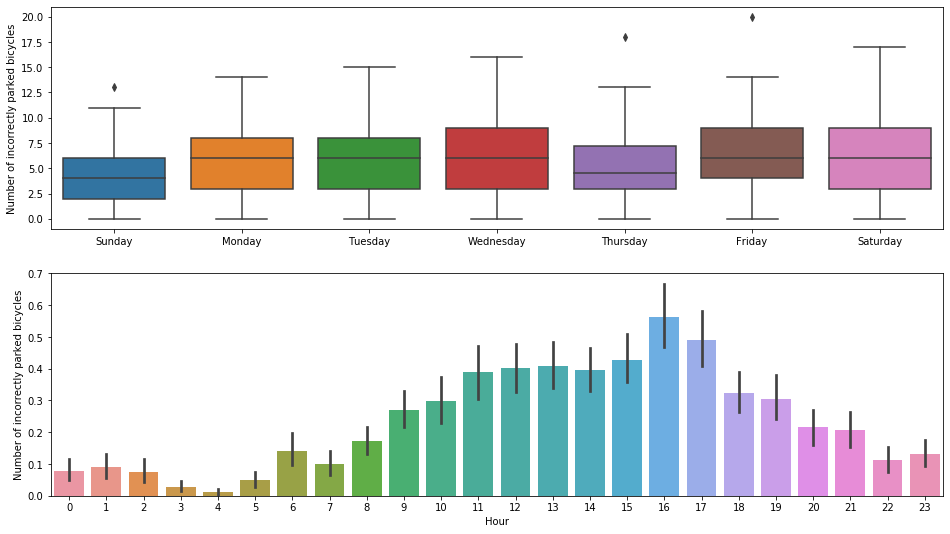

In [78]:
fig,axes = plt.subplots(nrows=2 ,figsize=(16,9)) 

sns.boxplot(x=ma_dist_near_station_resample_weekday.index.get_level_values(1), y=ma_dist_near_station_resample_weekday["is_far"],ax=axes[0])
sns.barplot(x=ma_dist_near_station_resample_hourly.index.get_level_values(1), y=ma_dist_near_station_resample_hourly["is_far"],ax=axes[1])

axes[0].set_xlabel('')
axes[1].set_xlabel('Hour')

for ax in axes:
    ax.set_ylabel('Number of incorrectly parked bicycles')


plt.show()

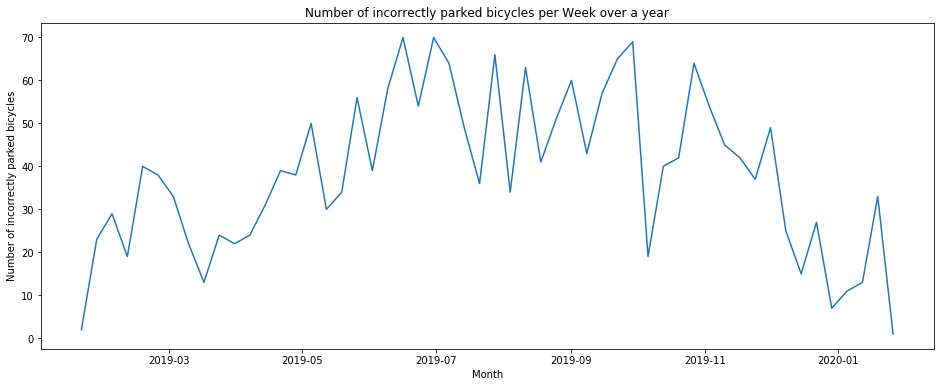

In [108]:
fig,ax = plt.subplots(figsize=(16,6))

ax.plot(ma_dist_near_station[ma_dist_near_station['is_far'] == True].resample('W')['is_far'].count())

ax.set_title('Number of incorrectly parked bicycles per Week over a year')
ax.set_xlabel('Month')
ax.set_ylabel('Number of incorrectly parked bicycles')

plt.show()

In [80]:
num_incorrect = marburg['is_far'].sum()
num_total = marburg['is_far'].count()
incorrect_per_trip = num_incorrect/num_total

print("""  Marburg

Total number of trips: {}
Total Number of incorrectly parked bicycles: {}
Incorrectly parked bicycles per 1000 trips: {:.4f}
""".format(num_total, num_incorrect, incorrect_per_trip*1000))

  Marburg

Total number of trips: 164057
Total Number of incorrectly parked bicycles: 2080
Incorrectly parked bicycles per 1000 trips: 12.6785



### Duisburg

In [91]:
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
duisburg_stations = pd.read_pickle('../0_data/stations/duisburg_stations.pkl')

### Calculate distance to nearest station for each trip

In [92]:
duisburg.insert(0, 'it_id', range(len(duisburg)))
duisburg_stations.insert(0,'it_id', range(len(duisburg_stations)))

In [93]:
trips_arr = np.array(list(duisburg['dest']))
stations_arr = np.array(list(duisburg_stations['coordinates']))

dist, station_it_id = calc_nearest_station(trips_arr, stations_arr)
station_it_id = pd.DataFrame(station_it_id)[0]
dist = pd.DataFrame(dist)[0]
nearest_stations = pd.DataFrame({
    'near_station_it_id':station_it_id,
    'near_station_dist':dist
})
nearest_stations.index.rename('trip_it_id', inplace=True)

In [94]:
# we create a dictionary containing the it_id as key and the real station id as value
it_id_to_station_id_dict = pd.Series(duisburg_stations.index, index=duisburg_stations['it_id']).to_dict()

nearest_stations['near_station_id'] = nearest_stations['near_station_it_id'].map(it_id_to_station_id_dict)

In [95]:
nearest_stations = nearest_stations.drop(['near_station_it_id'], axis=1)
duisburg_stations = duisburg_stations.drop(['it_id'], axis=1)

In [96]:
nearest_stations = nearest_stations.merge(right=duisburg_stations, left_on='near_station_id', right_index=True)
nearest_stations.rename(columns={'coordinates':'near_station_coor'}, inplace=True)
duisburg = duisburg.reset_index().merge(right=nearest_stations, how='outer', left_on='it_id', right_on='trip_it_id').set_index('datetime')

In [97]:
duisburg = duisburg.drop(['it_id'], axis=1)

In [98]:
duisburg['is_far'] = duisburg['near_station_dist'].map(lambda dist : dist>max_distance)

In [99]:
duisburg_incorrect = duisburg[duisburg['is_far'] == True]

### Plotting

In [100]:
Du_map = folium.Map(location=(51.44, 6.83), zoom_start=10, control_scale=True, max_zoom=20)
Du_map.add_child(plugins.HeatMap(duisburg_incorrect['dest'], radius=15))

for index, row in duisburg_stations.iterrows():
    folium.CircleMarker(radius=5, location=row.coordinates, color='black', fill_color='black', popup=row['name']).add_to(Du_map)

Du_map

In [101]:
# resample the KPI hourly
du_dist_near_station = duisburg.drop(duisburg.columns.difference(['near_station_dist','is_far']), 1)
du_dist_near_station_hourly = du_dist_near_station[du_dist_near_station['is_far'] == True].resample('h')['is_far'].count()
du_dist_near_station_hourly = pd.DataFrame(du_dist_near_station_hourly)

In [102]:
# we now add some columns for weekday, date and hour, in order to visualize the KPI grouped by weekday or hour
du_dist_near_station_hourly['weekday'] = du_dist_near_station_hourly.index.map(lambda datetime : datetime.weekday)

du_dist_near_station_hourly['weekday'] = du_dist_near_station_hourly['weekday'].map(day_of_week)

du_dist_near_station_hourly['date'] = du_dist_near_station_hourly.index.map(lambda datetime : datetime.date)
du_dist_near_station_hourly['hour'] = du_dist_near_station_hourly.index.map(lambda datetime : datetime.hour)

In [103]:
# group by date and weekday and then take the sum of the bikes that are parked 'far away' from the next station
du_dist_near_station_resample_weekday = du_dist_near_station_hourly.groupby(['date','weekday'])['is_far'].sum()
du_dist_near_station_resample_weekday = pd.DataFrame(du_dist_near_station_resample_weekday)

In [104]:
# group by date and hour and then take the sum of the bikes that are parked 'far away' from the next station
du_dist_near_station_resample_hourly = du_dist_near_station_hourly.groupby(['date','hour'])['is_far'].sum()
du_dist_near_station_resample_hourly = pd.DataFrame(du_dist_near_station_resample_hourly)

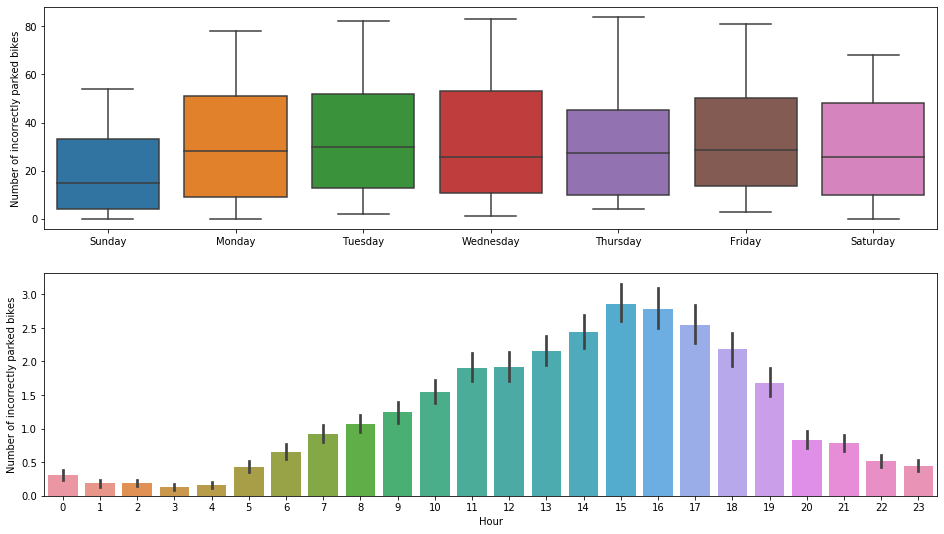

In [105]:
fig,axes = plt.subplots(nrows=2 ,figsize=(16,9)) 

sns.boxplot(x=du_dist_near_station_resample_weekday.index.get_level_values(1), y=du_dist_near_station_resample_weekday["is_far"],ax=axes[0])
sns.barplot(x=du_dist_near_station_resample_hourly.index.get_level_values(1), y=du_dist_near_station_resample_hourly["is_far"],ax=axes[1])

axes[0].set_xlabel('')
axes[1].set_xlabel('Hour')

for ax in axes:
    ax.set_ylabel('Number of incorrectly parked bicycles')


plt.show()

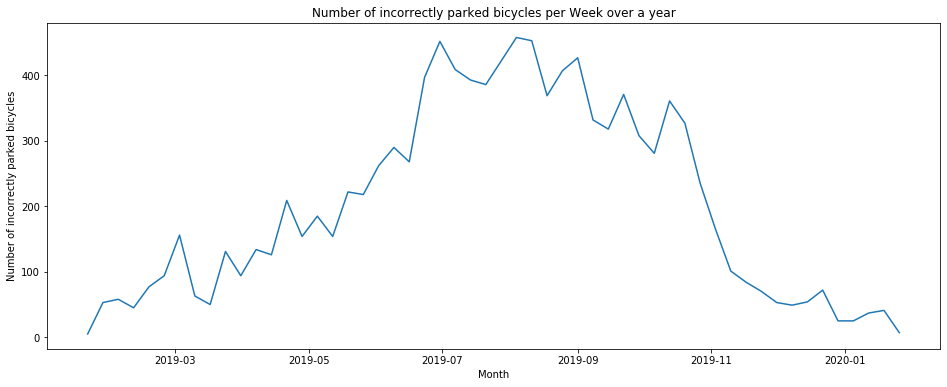

In [106]:

fig,ax = plt.subplots(figsize=(16,6))

ax.plot(du_dist_near_station[du_dist_near_station['is_far'] == True].resample('W')['is_far'].count())

ax.set_title('Number of incorrectly parked bicycles per Week over a year')
ax.set_xlabel('Month')
ax.set_ylabel('Number of incorrectly parked bicycles')

plt.show()


In [107]:
num_incorrect = duisburg['is_far'].sum()
num_total = duisburg['is_far'].count()
incorrect_per_trip = num_incorrect/num_total

print("""  Duisburg

Total number of trips: {}
Total Number of incorrectly parked bicycles: {}
Incorrectly parked bicycles per 1000 trips: {:.4f}
""".format(num_total, num_incorrect, incorrect_per_trip*1000))

  Duisburg

Total number of trips: 132107
Total Number of incorrectly parked bicycles: 10937
Incorrectly parked bicycles per 1000 trips: 82.7890

